# PROJECT: Classifying songs on the basis of their genre
- categorizing music to allow for personalized recommendations
- aim of this project is to examine the data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock'.


## Pipeline of this project
- Exploratory Data Analysis and Visualisation
- Feature Engineering
- Feature Selection
- Model Building

In [1]:
# importing dependencies
import pandas as pd
import seaborn as sb


In [2]:
# Reading track metadata with genre labels
tracks = pd.read_csv("datasets/fma-rock-vs-hiphop.csv")
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [3]:
# Reading track metrics with the features
echonest_metrics =pd.read_json("datasets/echonest-metrics.json",precise_float=True)
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [4]:
# Merging the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics,tracks[['track_id','genre_top']],on='track_id')
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [5]:
# checking for missing values
echo_tracks.isnull().sum()

track_id            0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
genre_top           0
dtype: int64

In [6]:
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


### Seems like our data is having numerical values only, we will try to avoid using variables that have strong correlations with each other - hence avoiding feature redundancy - for a few reasons:
- To keep the model simple and with many features, we run the risk of overfitting.
- in very large datasets, using fewer features can drastically speed up our computation time.


In [7]:
# finding corelation between the numerical features
# using .corr() 
# Creating a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


## Splitting the data
- Since we didn't find any particularly strong correlations between our features, we can now split our data into an array containing our features, and another containing the labels - the genre of the track.

In [8]:
from sklearn.model_selection import train_test_split
#creating features
features = echo_tracks.drop(['genre_top','track_id'],axis=1).values
features

array([[4.16675233e-01, 6.75893985e-01, 6.34476268e-01, ...,
        1.59310065e-01, 1.65922000e+02, 5.76660988e-01],
       [3.74407769e-01, 5.28643062e-01, 8.17461132e-01, ...,
        4.61818128e-01, 1.26957000e+02, 2.69240242e-01],
       [4.35668989e-02, 7.45565870e-01, 7.01469992e-01, ...,
        1.24595342e-01, 1.00260000e+02, 6.21661224e-01],
       ...,
       [1.04777022e-02, 6.52483062e-01, 6.57497709e-01, ...,
        2.29174375e-01, 9.48850000e+01, 4.32240157e-01],
       [6.79063452e-02, 4.32421004e-01, 7.64508334e-01, ...,
        3.10552525e-01, 1.71329000e+02, 5.80087111e-01],
       [1.53518164e-01, 6.38659813e-01, 7.62567227e-01, ...,
        3.03372337e-01, 7.78420000e+01, 6.56612274e-01]])

In [9]:
#creating labels
# Create labels
labels = echo_tracks['genre_top'].values
labels


array(['Hip-Hop', 'Hip-Hop', 'Hip-Hop', ..., 'Hip-Hop', 'Hip-Hop',
       'Hip-Hop'], dtype=object)

In [10]:
# splitting the data in training dataset nd testing data set
train_features, test_features, train_labels, test_labels = train_test_split(features,labels,random_state=5)

### Normalizing the feature data
- As we didnt get any strong corelation in our features so that we could have remove some features, now we will PCA to reduce the no of features features
- Before that we will do some scaling in our both test and train features

In [11]:
# Importing the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
# Scaling train_features 
scaled_train_features = scaler.fit_transform(train_features)
scaled_train_features

array([[ 1.34237282,  0.86164357, -0.76064822, ..., -0.52300103,
        -0.7469662 ,  0.76627323],
       [ 0.91021001, -0.90179286, -0.68884823, ..., -0.46476374,
        -0.52548805,  0.42553405],
       [-1.31127826, -0.55943596, -0.11270637, ..., -0.50067552,
        -1.74752766,  0.9418221 ],
       ...,
       [ 0.51797147, -0.55877711,  1.46379638, ...,  1.85941037,
         0.5712021 , -1.25983123],
       [ 0.62703932,  0.91228132, -0.36835378, ..., -0.18420972,
         1.75899403,  1.02637558],
       [ 0.29905541,  0.89167317, -1.08127423, ...,  0.14222451,
        -1.22002517,  0.85261577]])

In [13]:
# Scaling test_features
scaled_test_features = scaler.transform(test_features)
scaled_test_features

array([[ 0.44310988,  0.95965855,  0.06040876, ...,  0.3297547 ,
        -0.48297977,  1.84262139],
       [-1.03367883, -0.15252051, -0.9354748 , ..., -0.425692  ,
        -1.79647392, -0.35518857],
       [ 1.35055822,  0.50955776, -1.21533224, ..., -0.45565444,
        -0.4125148 , -0.81527488],
       ...,
       [-1.24526049,  0.01897586,  0.42751129, ..., -0.44671296,
        -0.11019449, -0.39769534],
       [ 0.62991477,  0.41134242, -0.31065913, ...,  1.93929294,
         1.22878699,  0.38430068],
       [ 1.33655941,  0.44241384, -0.92697657, ..., -0.53565025,
        -1.04561186,  0.2701136 ]])

### PCA on our scaled data
- to determine by how much we can reduce the dimensionality of our data. We can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

In [14]:
# Importing our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

In [15]:
# Getting our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)

exp_variance = pca.explained_variance_ratio_

Text(0.5, 0, 'Principal Component #')

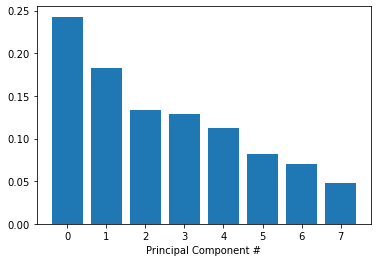

In [16]:

# plotting the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(8), exp_variance)
ax.set_xlabel('Principal Component #')

###  Further visualization of PCA

- As here does not appear to be a clear elbow in this scree plot, now looking at the cumulative explained variance plot to determine how many features are required to explain, say, about 85% of the variance

In [17]:
import numpy as np
# Calculating the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

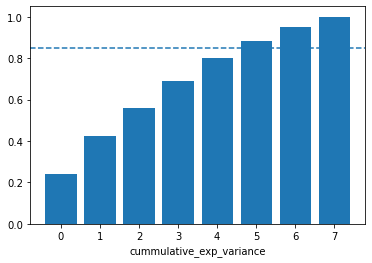

In [18]:
# Plotting the cumulative explained variance and drawing a dashed line at 0.85.
fig, ax = plt.subplots()
ax.bar(range(8),cum_exp_variance)
ax.set_xlabel('cummulative_exp_variance')
ax.axhline(y=0.85, linestyle='--')

In [19]:
##We saw from the plot that 6 features, can explain 85% of the variance!

##Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.

In [20]:
# Performing PCA with the chosen number of components and projecting data onto components
pca = PCA(n_components=6,random_state=10)

In [21]:
# Fitting and transforming the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)


In [22]:
# Fitting and transforming the scaled test features using pca
test_pca = pca.fit_transform(scaled_test_features)

### Model building 
- Here we will us two algorithms to test our model and compare between those two:
 - Decesion Tree
 - Logistic Regression
  

In [23]:
## Decesion Tree
from sklearn import tree

# Training our decision tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(train_pca,train_labels)


DecisionTreeClassifier(random_state=0)

In [24]:
# Predicting the labels for the test data
pred_labels_tree = clf.predict(test_pca)

In [25]:
## Logistics Regression
# Importing LogisticRegression
from sklearn.linear_model import LogisticRegression

In [26]:
# Training our logistic regression  
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca,train_labels)


LogisticRegression(random_state=10)

In [27]:
# predicting labels for the test set
pred_labels_logit = logreg.predict(test_pca)

### Comparing our decesion tree to logistisc regression


In [28]:
# Creating the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

In [29]:
# Decision tree report
print("Decision Tree: \n", class_rep_tree)


Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.48      0.52      0.50       233
        Rock       0.88      0.87      0.87       968

    accuracy                           0.80      1201
   macro avg       0.68      0.69      0.69      1201
weighted avg       0.80      0.80      0.80      1201



In [30]:
# Logistic Rregression report
print("Logistic Regression: \n", class_rep_log)

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.48      0.58       233
        Rock       0.88      0.96      0.92       968

    accuracy                           0.87      1201
   macro avg       0.82      0.72      0.75      1201
weighted avg       0.86      0.87      0.86      1201



## Data balancing
-  looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.
- looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes

In [31]:
## handling the imbalanced data
# getting only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top']=='Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top']=='Rock']

In [32]:
# sampling the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0],random_state=10)

In [33]:
print(hop_only.shape)
print(rock_only.shape)

(910, 10)
(910, 10)


In [34]:
# concatenating the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only,hop_only])

In [35]:
rock_hop_bal

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
773,4038,0.825838,0.263645,0.797948,8.423181e-01,0.177089,0.045277,166.580,0.713586,Rock
2273,19501,0.966635,0.386114,0.651980,8.694723e-01,0.353138,0.032208,130.767,0.712374,Rock
2846,31252,0.721510,0.358035,0.948187,8.011837e-01,0.105706,0.095522,125.884,0.208728,Rock
2147,17947,0.617370,0.487321,0.918848,8.170503e-01,0.089908,0.040337,129.565,0.268893,Rock
2654,27421,0.025464,0.245523,0.422381,9.380106e-01,0.441009,0.038795,149.960,0.439876,Rock
...,...,...,...,...,...,...,...,...,...,...
4797,124718,0.412194,0.686825,0.849309,6.000000e-10,0.867543,0.367315,96.104,0.692414,Hip-Hop
4798,124719,0.054973,0.617535,0.728567,7.215700e-06,0.131438,0.243130,96.262,0.399720,Hip-Hop
4799,124720,0.010478,0.652483,0.657498,7.098000e-07,0.701523,0.229174,94.885,0.432240,Hip-Hop
4800,124721,0.067906,0.432421,0.764508,1.625500e-06,0.104412,0.310553,171.329,0.580087,Hip-Hop


In [36]:
#again the features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

In [37]:
# splitting of training set and test set data
train_features, test_features, train_labels, test_labels = train_test_split(features,labels, random_state=10)

In [38]:
# Redefining the train and test set with the pca_projection from the balanced data
train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

### Checking if balancing the data helped?

In [39]:
# Training our decision tree on the balanced data
clf = tree.DecisionTreeClassifier(random_state=10)
clf.fit(train_features,train_labels)
pred_labels_tree = clf.predict(test_features)

In [40]:
# Training our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
# Comparing the models
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))


Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.85      0.83       230
        Rock       0.84      0.79      0.81       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



In [42]:
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.82      0.83       230
        Rock       0.82      0.84      0.83       225

    accuracy                           0.83       455
   macro avg       0.83      0.83      0.83       455
weighted avg       0.83      0.83      0.83       455



In [43]:
## as we can see balancing the data has really helped us in removing the biasing nature of our model

### Now using cross-validation to evaluate our models

In [44]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline


In [45]:
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", tree.DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

In [46]:
# Setting up our K-fold cross-validation
kf = KFold(10)

# Training our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

In [47]:
# Printing the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7582417582417582 Logistic Regression: 0.782967032967033
